## Analysis of the Indian Railway Network

Network Science Mini Project

> HARSHITA PANDEY - MT19012

> ROSE VERMA - MT19052

> SURYANK TIWARI - MT19019

This notebook comprises of **Network Loading, Preprocessing, Pickling and Visualization of the Indian Railway Netwok**. The data is loaded and processed as various graph types. In this notebook, we have also created **a subgraph querying system.**

## Network loading

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')
import networkx as nx

In [2]:
railway_data = pd.read_csv("Train_details_22122017.csv")
modified_railway_data = railway_data.dropna()

This is the snapshot of the government provided dataset for the Indian Railway Network - [IRN Timetable 01.11.17](https://data.gov.in/catalog/indian-railways-train-time-table-0?filters%5Bfield_catalog_reference%5D=332021&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc) 


In [4]:
modified_railway_data.head(10)

Train No    Train Name SEQ Station Code  Station Name Arrival time  \
0      107  SWV-MAO-VLNK   1          SWV  SAWANTWADI R      0:00:00   
1      107  SWV-MAO-VLNK   2         THVM        THIVIM     11:06:00   
2      107  SWV-MAO-VLNK   3         KRMI       KARMALI     11:28:00   
3      107  SWV-MAO-VLNK   4          MAO   MADGOAN JN.     12:10:00   
4      108  VLNK-MAO-SWV   1          MAO   MADGOAN JN.      0:00:00   
5      108  VLNK-MAO-SWV   2         KRMI       KARMALI     21:04:00   
6      108  VLNK-MAO-SWV   3         THVM        THIVIM     21:26:00   
7      108  VLNK-MAO-SWV   4          SWV  SAWANTWADI R     22:25:00   
8      128  MAO-KOP SPEC   1          MAO   MADGOAN JN.     19:40:00   
9      128  MAO-KOP SPEC   2         KRMI       KARMALI     20:18:00   

  Departure Time Distance Source Station Source Station Name  \
0       10:25:00        0            SWV     SAWANTWADI ROAD   
1       11:08:00       32            SWV     SAWANTWADI ROAD   
2       11:30:00       49            SWV     SAWANTWADI ROAD   
3        0:00:00       78            SWV     SAWANTWADI ROAD   
4       20:30:00        0            MAO         MADGOAN JN.   
5       21:06:00       33            MAO         MADGOAN JN.   
6       21:28:00       51            MAO         MADGOAN JN.   
7        0:00:00       83            MAO         MADGOAN JN.   
8       19:40:00        0            MAO         MADGOAN JN.   
9       20:20:00       33            MAO         MADGOAN JN.   

  Destination Station            Destination Station Name  
0                 MAO                         MADGOAN JN.  
1                 MAO                         MADGOAN JN.  
2                 MAO                         MADGOAN JN.  
3                 MAO                         MADGOAN JN.  
4                 SWV                     SAWANTWADI ROAD  
5                 SWV                     SAWANTWADI ROAD  
6                 SWV                     SAWANTWADI ROAD  
7                 SWV                     SAWANTWADI ROAD  
8                 KOP  CHHATRAPATI SHAHU MAHARAJ TERMINUS  
9                 KOP  CHHATRAPATI SHAHU MAHARAJ TERMINUS

## Graph Generation 


The function below is used to read the data CSV and convert it into a graph.

There are several __parameters__ which may be passed to the **generate_graph** function. Their usecases are presented below:

1. *__railway_data__*: This is the dataframe of the excel sheet. Used to load data and generate a graph.
2. *__filter_nodes__*: Default=None. If None then all nodes (railway stations) are added to a graph. If a list of nodes is provided (a list of station codes) then only those nodes and their neighbours will be added to the graph. This option is used to generate a subgraph and query the IRN.
3. *__distance_weighted__*: Default=False. This parameter dictates the edge weight property. *__If True then distance between two railway stations is considered as the edge weight. If False then the number of trains between the stations is considered as the edge weight.__*
4. *__pickle__*: Default=False. If true then saves pickles.

**Heuristic for edge between two nodes**: If a train passes between two stations then the two stations will be connected via an edge. i.e. if a train passes through the stations - A, B, C and D then A, B, C, D will form a completely connected subgraph as one train connects them all.

The function returns a directed weighted graph governed by the parameters discussed above.


In [5]:
STATION_CODE = 'Station Code'
SOURCE_STATION = 'Source Station'
DESTINATION_STATION = 'Destination Station'
TRAIN_NAME = 'Train Name'
TRAIN_NO = 'Train No'
DISTANCE = 'Distance'

def generate_graph(railway_data, filter_nodes=None, distance_weighted=False):

    # make an empty directed graph
    graph = nx.DiGraph()
    stations = None

    # add all stations if there are none to filter
    if filter_nodes==None:
      stations = np.unique(railway_data[STATION_CODE])
    else:
      stations = filter_nodes
    
    graph.add_nodes_from(stations)
    
    # find all unique trains
    trains = np.unique(railway_data[TRAIN_NAME].astype('str'))
    
    # iterate over all trains
    for train_name in trains:

      # find out the stations the train visits
      train_route = railway_data.loc[railway_data[TRAIN_NAME] == train_name]
      stations_in_route = train_route[STATION_CODE].to_list()
      station_distances = train_route[DISTANCE].to_list()

      # make a connected graph out of all stations in route
      for source_station_itr in range(len(stations_in_route)):
        for destination_station_itr in range(source_station_itr+1, len(stations_in_route)):
          # Only add edge if node is present in the nodes to be filtered, or no node is to be filtered (i.e. add all)
          if filter_nodes==None \
            or stations_in_route[source_station_itr] in filter_nodes \
            or stations_in_route[destination_station_itr] in filter_nodes:

            if distance_weighted:
              # edge weight is the distance between the two nodes
              distance = int(station_distances[destination_station_itr]) - int(station_distances[source_station_itr])
            else:
              # edge weight is the number of trains passing through the two stations
              distance = 1

            # if edge exists already then increment weight
            if graph.has_edge(stations_in_route[source_station_itr], stations_in_route[destination_station_itr]):
                graph[stations_in_route[source_station_itr]][stations_in_route[destination_station_itr]]['weight'] += distance
            else:
                graph.add_edge(stations_in_route[source_station_itr], stations_in_route[destination_station_itr], weight=distance, label=train_name)
    return graph

## General analysis of train count weighted railway network.

In this section, we take the edge weight as the number of trains passing between two railway stations.

In [6]:
try:
  railway_network = nx.read_gpickle("Railway Network train_count_weighted.gpickle")
except:
  railway_network = generate_graph(modified_railway_data)
  # nx.write_gpickle(railway_network, "/content/drive/MyDrive/Network Science Project/Data/Railway Network train_count_weighted.gpickle")
print(nx.info(railway_network))

DiGraph with 8147 nodes and 902602 edges


As we can see above, IRN has total **8147 railway stations** . With our heuristic stated above, we have a total of 902602 edges with average in and out degree as 110.7895
This graph is a directed depiction of the IRN. Converting it to Undirected and noticing the same details.

In [ ]:
railway_network_undirected = railway_network.to_undirected()
print(nx.info(railway_network_undirected))

Name: 
Type: Graph
Number of nodes: 8147
Number of edges: 500412
Average degree: 122.8457


We notice that the number of nodes is the same while the number of edges decrease, which is to be expected. The average degree has also increased from 110.7895 to 122.8457.

In [ ]:
print('Number of connected components in IRN:', nx.number_connected_components(railway_network_undirected))

Number of connected components in IRN: 7


**The number of connected components in IRN is 7.** Which means that the entire railway network is not connected. i.e. There will be some stations we cannot reach starting from some stations.

## General analysis of distance weighted railway network.

In this section, we take the distance between the two stations as the number of trains passing between two railway stations.

In [ ]:
try:
  railway_network_distance_weighted = nx.read_gpickle("Railway Network distance_weighted.gpickle")
except:
  railway_network_distance_weighted = generate_graph(modified_railway_data)
  nx.write_gpickle(railway_network_distance_weighted, "/content/drive/MyDrive/Network Science Project/Data/Railway Network distance_weighted.gpickle")
print(nx.info(railway_network_distance_weighted))

Name: 
Type: DiGraph
Number of nodes: 8147
Number of edges: 902602
Average in degree: 110.7895
Average out degree: 110.7895


As expected, the details don't differ much. Only difference will be in the edge weights used. This can be verified by visualizing.

So, all facts stated above for train-count weighted network also apply for the distance-weighted network.

## Computing regions between two nodes -  Subgraph Querying and Visualization System 

In this section we visualize a set of nodes specified, their neighbours and the shortest path between them.

The following function **get_subgraph** makes use of the **generate_graph** function with **filter_nodes** to make a subgraph of the nodes we need the subgraph for.

Parameters:
1. *__railway_data__*: The dataframe of the loaded IRN. It is used to create a subgraph of all queried nodes, their neighbours and the nodes in the shortest path of the queried nodes.
2. *__graph__*: The graph which we are querying (generating subgraph from). It is used to find shortest path between the nodes being queried.
3. *__subgraph_nodes__*: These are the nodes that are being queried. A subgraph of these nodes, their neighbours and their connecting nodes will be generated.
4. *__distance_weighted__*: True if the edge weight is distance-weighted, False if it is train_count-weighted.
5. *__plot__*: Whether the subgraph is to be plotted or not.

In [ ]:
# subgraph_nodes are the nodes being queried
def get_subgraph(railway_data, graph, subgraph_nodes, distance_weighted=False, plot=True):
  # create an empty graph
  sub_graph=nx.empty_graph(0,create_using=nx.DiGraph())

  # go through all combinations of nodes
  for node1_itr in range(len(subgraph_nodes)):
    for node2_itr in range(node1_itr+1, len(subgraph_nodes)):
      print(subgraph_nodes[node1_itr], subgraph_nodes[node2_itr])

      # generate a subgraph of the source and destination node and their neighbours
      sub_sub_graph = generate_graph(railway_data, [subgraph_nodes[node1_itr], subgraph_nodes[node2_itr]], distance_weighted)

      # append the earlier generated subgraph with a subgraph that connects the source and destination via the shortest path.
      # if no connection is found between the two nodes then the resultant graph will be disconnected.
      sub_sub_graph = nx.compose(sub_sub_graph, railway_network.subgraph([subgraph_nodes[node1_itr], subgraph_nodes[node2_itr]]))

      # append the graph to the main graph so all changes are retained
      sub_graph = nx.compose(sub_graph, sub_sub_graph)    

  # convert the graph to undirected
  sub_graph = sub_graph.to_undirected()

  # plot the graph
  if plot:
    plt.figure(figsize=(10,10))

    # using spring layout for maximum visibility
    pos = nx.spring_layout(sub_graph)

    # draw the subgraph
    nx.draw(sub_graph, pos, node_color='k', node_size=100)

    # find the nodes and edges in the shortest paths (connecting the queried nodes)
    path_edges = []
    path_nodes = []
    for node1_itr in range(len(subgraph_nodes)):
      for node2_itr in range(node1_itr+1, len(subgraph_nodes)):
        try:
          path = nx.shortest_path(graph,source=subgraph_nodes[node1_itr],target=subgraph_nodes[node2_itr])
          for node_itr in range(len(path)-1):
            path_edges.append((path[node_itr], path[node_itr+1]))
          path_nodes.extend(path)
        except:
          pass
    
    # draw the connecting nodes in red
    nx.draw_networkx_nodes(sub_graph, pos, nodelist=path_nodes, node_color='r')
    
    # draw the queried nodes in a larger size and red color
    nx.draw_networkx_nodes(sub_graph, pos, nodelist=subgraph_nodes, node_color='r', node_size=400)

    # draw shortest path in red
    nx.draw_networkx_edges(sub_graph, pos, edgelist=path_edges, edge_color='r', width=8)

    # draw labels for the queried nodes and the connecting nodes
    nx.draw_networkx_labels(sub_graph.subgraph(subgraph_nodes), pos, font_color='pink', font_size=18, font_weight='bold')
    nx.draw_networkx_labels(sub_graph.subgraph([station for station in path_nodes if station not in subgraph_nodes]), pos, font_color='pink', font_size=15)
    plt.axis('equal')
    plt.show()
  return sub_graph

With this function, we can query the IRN graph. Any number of station-codes can be passed to the function for querying. 

__The following is the subgraph querying and visualization demo for the station codes: DAA and SWV with train count as edge weights__

DAA SWV


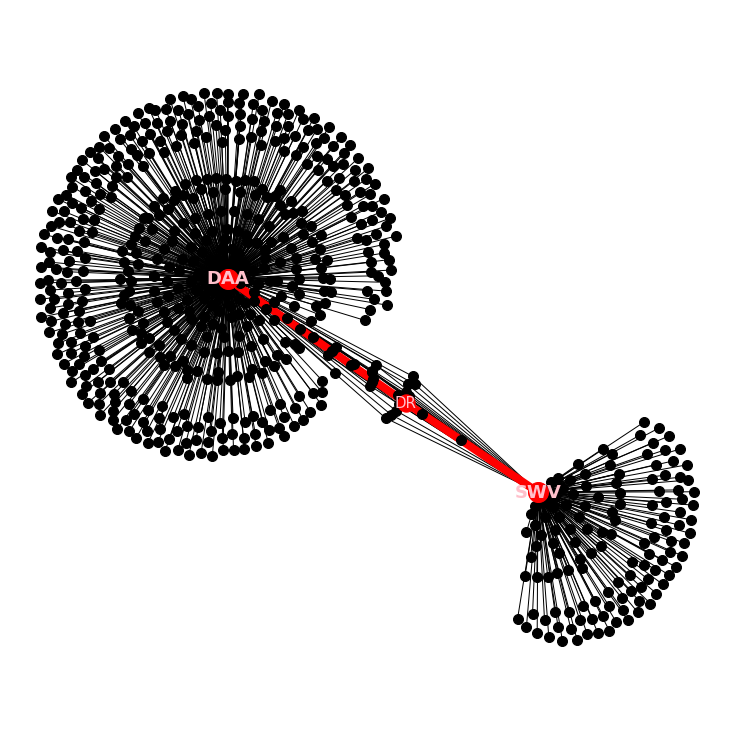

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['DAA', 'SWV'])

We can see that the three queried nods have been marked in big red nodes and their label is marked in bold color. The shortest path connecting the nodes is marked in RED. Any nodes that appear in the shortest path are also drawn in a smaller red node and labelled with normal text.

__The demo for the same sub-graph but with distance based edge weights is as follows:__

DAA SWV


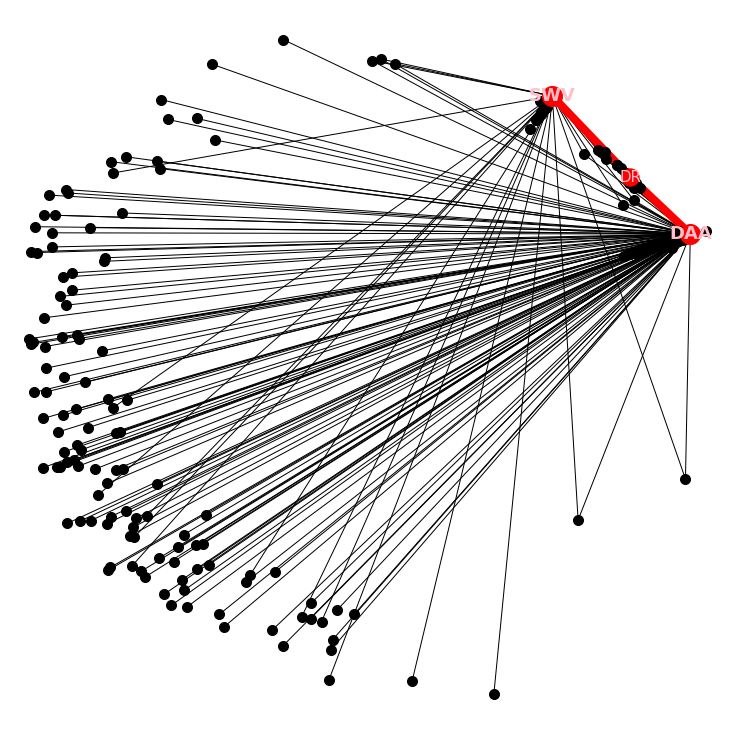

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network, ['DAA', 'SWV'], distance_weighted=True)

We can see that in distance based edge weights, there was grouping of neighbours based on how far away they were. Neighbours are not grouped close-by but based on how far they are.

Demoing the same two graph types with different and more number of stations: **New Delhi, Bangalore and Dehradun:**

NDLS BNCE
NDLS DDN
BNCE DDN


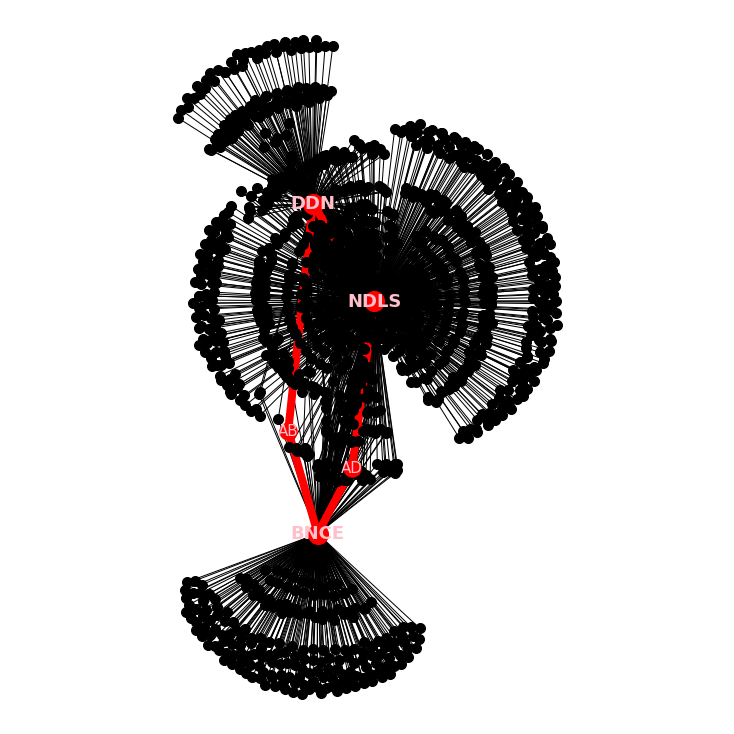

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network_undirected, ['NDLS', 'BNCE', 'DDN'])

The stations chosen in this subgraph are big cities so they have a very dense neighbour cluster which is to be expected.

NDLS BNCE
NDLS DDN
BNCE DDN


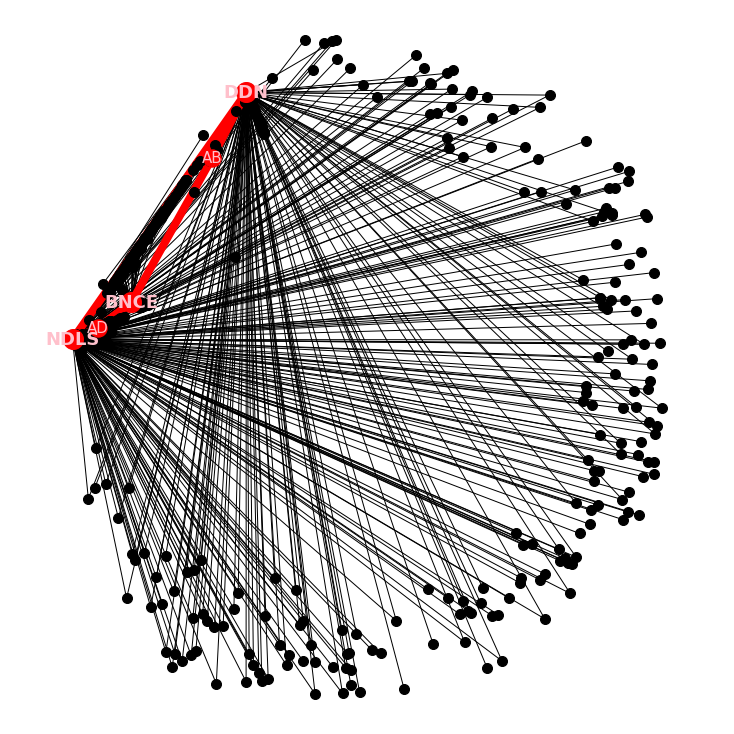

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network_undirected, ['NDLS', 'BNCE', 'DDN'], distance_weighted=True)

Third demo with different stations:

DAA UHP
DAA CUR
UHP CUR


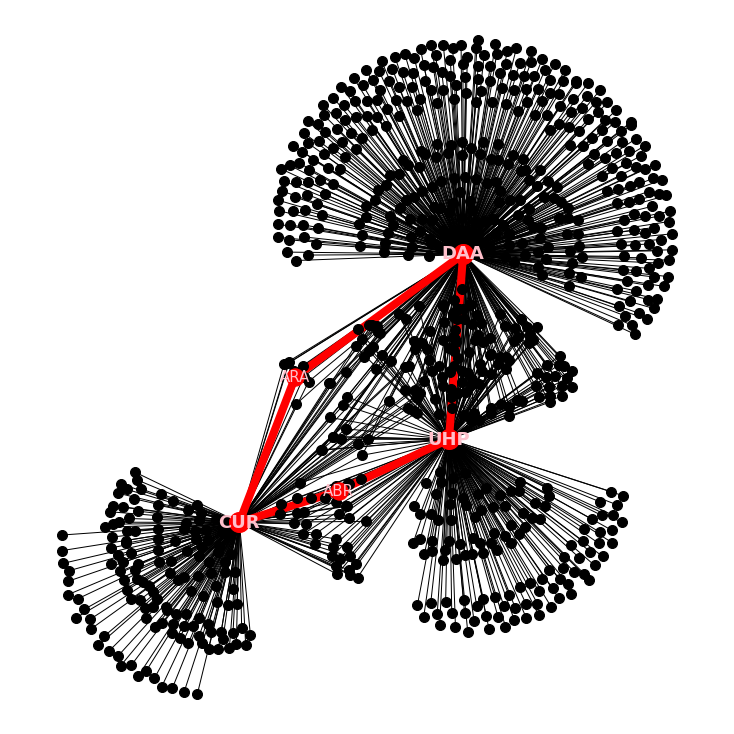

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network_undirected, ['DAA', 'UHP', 'CUR'])

DAA UHP
DAA CUR
UHP CUR


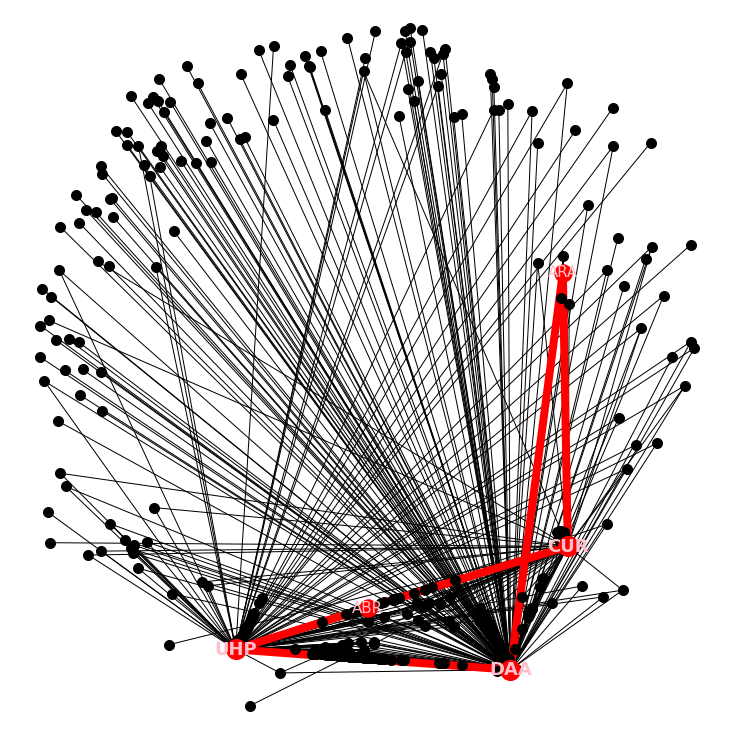

In [ ]:
subgraph = get_subgraph(modified_railway_data, railway_network_undirected, ['DAA', 'UHP', 'CUR'], distance_weighted=True)

## Interactive Plots
The above generated subgraphs are also presented in an interactive plot which can be zoomed, panned around and hovered for station details.

In [ ]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
output_notebook()

In [ ]:
def plot_interactive(graph):
  title = 'Railway Network Subgraph'
  hover_details = [("Station", "@index")]
  plot = figure(tooltips = hover_details, tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', title=title)
  network_graph = from_networkx(graph, nx.spring_layout, scale=10, center=(0, 0))
  network_graph.node_renderer.glyph = Circle(size=13, fill_color='skyblue')
  network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
  plot.renderers.append(network_graph)
  show(plot)

plot_interactive(subgraph)

Since the interactive plot only shows up when the notebook is run, here is a GIF of the working of the interactive plot.

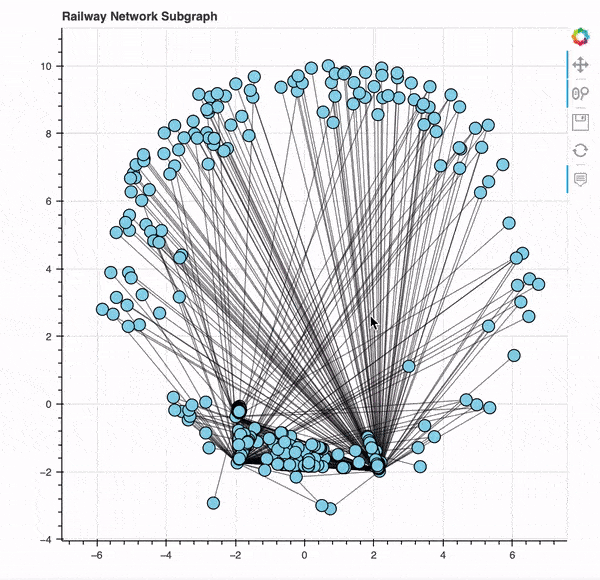

In [ ]:
from IPython.display import Image
Image(open('Interactive graph demo.gif','rb').read())